In [1]:
# MEJNw2yQ
import pandas as pd
import requests
import glob
import os

import geopandas as gpd
# import folium
from scipy.interpolate import griddata
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from thermal import Params, simulate_day

In [ ]:
files = glob.glob('./ghcn_hourly_data/GHCNh_*.parquet')
print(f"Found {len(files)} files")

columns = [
  "Station_ID",
  # "Station_name",
  "DATE",
  "Latitude",
  "Longitude",
  "Elevation",
  "temperature",
  "wind_speed",
  "relative_humidity",
  # "wet_bulb_temperature",
  # "altimeter",
  # "precipitation"
]

N = len(files)

df_stations = []
for i in range(N):
  if i % 100 == 0:
    print(f"Processing file {i} of {N}")
  df = pd.read_parquet(files[i], engine="pyarrow", columns=columns)

  # Interpolate or aggregate the DATE column to get only hourly data
  df['DATE'] = pd.to_datetime(df['DATE'])
  df.set_index('DATE', inplace=True)
  df_hourly = df.resample('1h').mean(numeric_only=True).reset_index()
  df_hourly["Station_ID"] = df.iloc[0]["Station_ID"]
  df_stations.append(df_hourly)

df_stations = pd.concat(df_stations)
df_stations.to_parquet("./ghcn_hourly_combined.parquet")

In [40]:
df = pd.read_parquet("./ghcn_hourly_combined.parquet")
df.rename(columns={'Latitude': 'latitude', 'Longitude': 'longitude', 'Elevation': 'elevation', 'DATE': 'ds'}, inplace=True)
df["month"] = df["ds"].dt.month
df["hour"] = df["ds"].dt.hour

In [ ]:
print(f"There are {df["Station_ID"].nunique()} unique locations")
num_stations = df["Station_ID"].nunique()
print(f"There are {len(df) / num_stations} measurements per station on average")

# For each station ID, impute missing hourly data with the mean of the other hours.
# df.temperature 

# Drop any stations with less than 80% complete data (0.80 * 8760 = 7008)
station_counts = df.groupby("Station_ID").size().reset_index(name="count")
station_counts

min_obs = 8760 * 0.80
df = df[df["Station_ID"].isin(station_counts[station_counts["count"] >= min_obs]["Station_ID"])]

print(f"After dropping stations with less than {min_obs} observations, there are {df['Station_ID'].nunique()} stations remaining")

# Now forward fill missing data
df = df.sort_values(by=["Station_ID", "ds"])
df = df.groupby("Station_ID").apply(lambda x: x.ffill()).reset_index(drop=True)

df

In [ ]:
# df.to_csv("./ghcn_hourly_combined_cleaned.csv")
df.to_parquet("./ghcn_hourly_combined_cleaned.parquet")

In [ ]:
# center_lat = df['latitude'].mean()
# center_lon = df['longitude'].mean()
# m = folium.Map(location=[center_lat, center_lon], zoom_start=10)

# for idx, row in df.iterrows():
#   folium.CircleMarker(
#     location=[row['latitude'], row['longitude']],
#     radius=8,
#     popup=f"Temperature: {row['temperature']}°C",
#     color='red',
#     fill=True,
#     fill_color='red'
#   ).add_to(m)
# # View the map
# m
print("Latitude range:", df['latitude'].min(), df['latitude'].max())
print("Longitude range:", df['longitude'].min(), df['longitude'].max())

fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Add map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Set map extent with some padding
# padding = 1  # degrees
# ax.set_extent([
#   df['longitude'].min() - padding,
#   df['longitude'].max() + padding,
#   df['latitude'].min() - padding,
#   df['latitude'].max() + padding
# ])

df_avg_temp = df.groupby(by=["latitude", "longitude"]).mean().reset_index()

# Simple scatter plot of points
scatter = ax.scatter(df_avg_temp['longitude'], df_avg_temp['latitude'],
                    c=df_avg_temp['temperature'],
                    cmap='RdYlBu_r',
                    s=100)
plt.colorbar(scatter, label='Temperature (°C)')

fig.show()

In [45]:
# For each location and month, calculate the average temperature at each hour.
df_cleaned = pd.read_parquet("./ghcn_hourly_combined_cleaned.parquet")

df_avg_temp = df_cleaned.groupby(by=["latitude", "longitude", "month", "hour"]).agg({
  "temperature": "mean",
  "wind_speed": "mean",
  "relative_humidity": "mean",
  "elevation": "mean",
  "Station_ID": "first",
}).reset_index()

# Drop any station IDs with less than 12*24 observations
df_avg_temp.to_parquet("./ghcn_avg_temp.parquet")

Plotting average day for station BRM00086666
Shifting hours by -3 hours


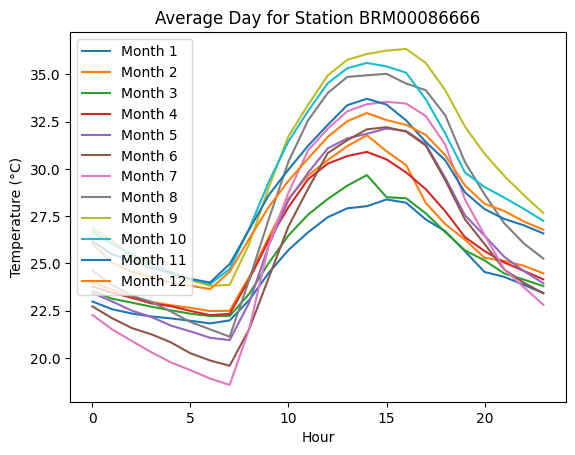

In [9]:
# Plot an average day for each month for a sample station
station_id = df_avg_temp["Station_ID"].unique()[1000]
print(f"Plotting average day for station {station_id}")

df_avg_temp_station = df_avg_temp[df_avg_temp["Station_ID"] == station_id].copy()

# Shift hours based on the longitude
num_hours_offset = int(df_avg_temp_station["longitude"].iloc[0] / 15)
print(f"Shifting hours by {num_hours_offset} hours")
if num_hours_offset < 0:
  num_hours_offset = 24 + num_hours_offset

df_avg_temp_station["hour"] = (df_avg_temp_station["hour"] + num_hours_offset) % 24

df_avg_temp_station = df_avg_temp_station.sort_values(by=["month", "hour"]).reset_index()

for month in df_avg_temp_station["month"].unique():
  df_month = df_avg_temp_station[df_avg_temp_station["month"] == month]
  plt.plot(df_month["hour"], df_month["temperature"], label=f"Month {month}")

plt.legend()
plt.title(f"Average Day for Station {station_id}")
plt.xlabel("Hour")
plt.ylabel("Temperature (°C)")
plt.show()


In [18]:
def process_station(df_station: pd.DataFrame, params: Params, target_temp: float) -> pd.DataFrame:
  # Shift hours based on the longitude
  num_hours_offset = int(df_station["longitude"].iloc[0] / 15)
  if num_hours_offset < 0:
    num_hours_offset = 24 + num_hours_offset

  print(f"Shifting hours by {num_hours_offset} hours")
  df_station["hour"] = (df_station["hour"] + num_hours_offset) % 24

  df_results = []
  df_hourly_results = []
  for month in df_station["month"].unique():
    df_month = df_station[df_station["month"] == month]
    # Use the middle day of the month as the day of the year
    day_of_year = df_month["month"].iloc[0] / 12 * 365 + 15
    results = simulate_day(params, df_month["temperature"].tolist(), target_temp=target_temp, day_of_year=day_of_year)
    df_results.append({
      "station_id": station_id,
      "month": month,
      "day_of_year": day_of_year,
      "target_temp": target_temp,
      "cooling_load_kwh": results['total_cooling_load_kwh'],
      "heating_load_kwh": results['total_heating_load_kwh'],
      "n_cooling_hours": len(results['daily_cooling_hours']),
      "n_heating_hours": len(results['daily_heating_hours']),
    })
    df_hourly = pd.DataFrame(results['hourly_results'])
    df_hourly["station_id"] = station_id
    df_hourly["month"] = month
    df_hourly["day_of_year"] = day_of_year
    df_hourly["target_temp"] = target_temp
    df_hourly["hour"] = range(24)
    df_hourly_results.append(df_hourly)

  return pd.DataFrame(df_results), pd.concat(df_hourly_results)


df_avg_temp = pd.read_parquet("./ghcn_avg_temp.parquet")

station_ids = df_avg_temp["Station_ID"].unique()
print(f"There are {len(station_ids)} unique stations")

params = Params(
  u_value=4.0,            # W/m²·K
  height=4.0,             # m
  infiltration_rate=0.5,  # air changes per hour
  thermal_mass=100000,    # J/m²·K
  glazing_transmittance=0.8,  # fraction
  latitude=0,            # degrees North
)

target_temp = 23
station_ids = station_ids[:2]

# for station_id in station_ids:
station_id = station_ids[0]
df_station = df_avg_temp[df_avg_temp["Station_ID"] == station_id].sort_values(by=["month", "hour"])

# Make sure there are no NaN temperatures:
if df_station["temperature"].isna().any():
  raise ValueError(f"Station {station_id} has NaN temperatures")

df_summary_results, df_hourly_results = process_station(df_station, params, target_temp)

df_summary_results
df_hourly_results


There are 9980 unique stations
Shifting hours by 19 hours


,conduction,infiltration,solar,thermal_mass,total,type,station_id,month,day_of_year,target_temp,hour
0,162.773333,27.832544,0.0,0.000000,190.605878,heating,AYM00089079,1,45.416667,23,0
1,162.773333,27.832544,0.0,12.190057,178.415820,heating,AYM00089079,1,45.416667,23,1
2,162.773333,27.832544,0.0,23.549383,167.056495,heating,AYM00089079,1,45.416667,23,2
3,162.773333,27.832544,0.0,33.303856,157.302021,heating,AYM00089079,1,45.416667,23,3
4,162.773333,27.832544,0.0,40.788727,149.817150,heating,AYM00089079,1,45.416667,23,4
...,...,...,...,...,...,...,...,...,...,...,...
19,156.151724,26.700318,0.0,-43.643224,226.495267,heating,AYM00089079,12,380.000000,23,19
20,156.151724,26.700318,0.0,-39.129444,221.981487,heating,AYM00089079,12,380.000000,23,20
21,156.151724,26.700318,0.0,-31.949058,214.801100,heating,AYM00089079,12,380.000000,23,21
22,156.151724,26.700318,0.0,-22.591395,205.443438,heating,AYM00089079,12,380.000000,23,22
